In [132]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale, minmax_scale, MinMaxScaler
import utils

In [134]:
df = pd.read_csv("data/dinosaurs.csv", sep=";")
df.head()

,age,mass,species,sp_id
0,1,162.7,Maiasaura peeblesorum,2
1,5,423.1,Maiasaura peeblesorum,2
2,6,1429.0,Maiasaura peeblesorum,2
3,1,0.5,Shuvuuia deserti,5
4,2,0.6,Shuvuuia deserti,5


In [135]:
df.describe()

,age,mass,sp_id
count,32.000000,32.000000,32.000000
mean,6.250000,1797.184375,3.625000
std,3.750269,5648.730658,1.601411
min,1.000000,0.500000,1.000000
25%,3.750000,5.900000,3.000000
50%,5.500000,18.450000,3.500000
75%,8.000000,169.850000,5.000000
max,15.000000,25427.400000,6.000000


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      32 non-null     int64  
 1   mass     32 non-null     float64
 2   species  32 non-null     object 
 3   sp_id    32 non-null     int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 1.1+ KB


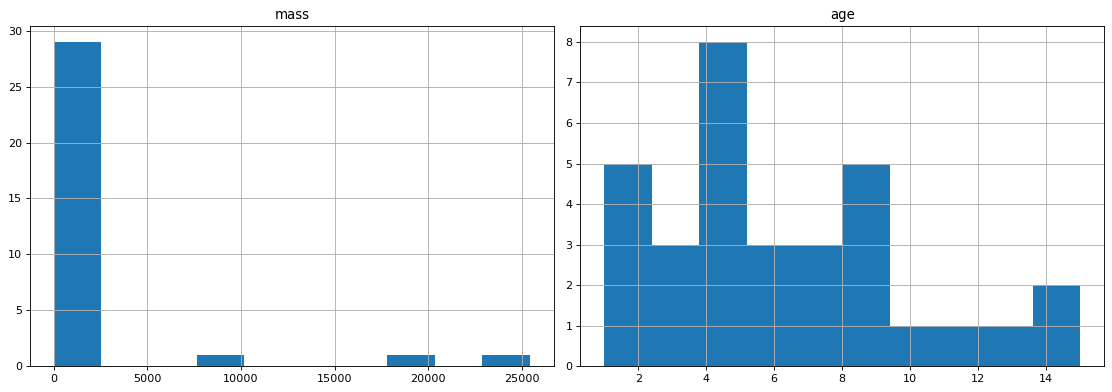

In [137]:
plt.figure(figsize=(14,5), dpi=80)
plt.subplot(1,2,1)
df.mass.hist()
plt.title("mass")

plt.subplot(1,2,2)
df.age.hist()
plt.title("age")
plt.tight_layout()

In [138]:
mass_scaler = MinMaxScaler()
# df['mass_norm'] = mass_scaler.fit_transform(df.mass.values.reshape(-1, 1)).squeeze()

g = df.groupby("sp_id")
sp_mass_max = g.mass.max()
df['mass_norm'] = g.mass.transform(lambda x: x/x.max())
df['log_mass'] = np.log(df.mass)
df['age_norm'] = minmax_scale(df.age)
species = pd.Categorical(df.species)
s_id = species.codes
df['s_id'] = s_id

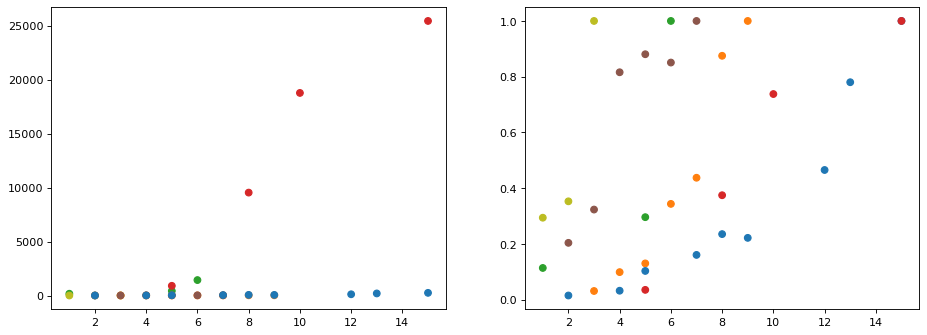

In [139]:
color = {"Apatosaurus excelsus": "tab:red", "Maiasaura peeblesorum": "tab:green",
         "Massospondylus carinatus": "tab:blue", "Psittacosaurus mongoliensis": "tab:orange",
         "Shuvuuia deserti": "tab:olive", "Syntarsus rhodesiensis": "tab:brown"
}
plt.figure(figsize=(14,5), dpi=80)
plt.subplot(1,2,1)
plt.scatter(x=df.age, y=df.mass, c=df.species.map(color))

plt.subplot(1,2,2)
plt.scatter(x=df.age, y=df.mass_norm, c=df.species.map(color))

# Models

In [140]:
with pm.Model() as model1:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    mu = alpha + beta * df.age_norm

    sigma = pm.HalfCauchy("sigma", beta=10)
    mass = pm.Normal("mass", mu=mu, sigma=sigma, observed=df.mass_norm)
    samples1 = pm.sample(chains=1)
    posterior1 = pm.sample_posterior_predictive(samples1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, beta, sigma]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.


In [141]:
with pm.Model() as model2:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    mu = alpha + beta * df.age_norm

    sigma = pm.Exponential("sigma", lam=1)
    mass = pm.Normal("mass", mu=mu, sigma=sigma, observed=df.mass_norm)
    samples2 = pm.sample(chains=1)
    posterior2 = pm.sample_posterior_predictive(samples2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, beta, sigma]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.


In [142]:
with pm.Model() as model3:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    coef = pm.Normal("beta", mu=0, sigma=1)
    beta = alpha + coef * df.age_norm

    sigma = pm.Exponential("sigma", lam=1)
    log_mass = pm.Normal("log_mass", mu=beta, sigma=sigma, observed=df.log_mass)
    samples3 = pm.sample(chains=1)
    posterior3 = pm.sample_posterior_predictive(samples3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, beta, sigma]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.


In [143]:
with pm.Model(coords={"s_id_dim": np.unique(s_id)}) as model4:
    _s_id = pm.MutableData("s_id", s_id)
    age = pm.MutableData("age", df.age)
    mass_data = pm.MutableData("mass_data", df.mass_norm)

    sigma = pm.Exponential("sigma", lam=1)
    general = pm.Normal("general", mu=0, sigma=1)
    alpha = pm.Normal("alpha", mu=general, sigma=1, dims="s_id_dim")
    beta = pm.Normal("beta", mu=0, sigma=1, dims="s_id_dim")

    mu = beta[_s_id] * age

    mass = pm.Normal("mass", mu=mu, sigma=sigma, observed=mass_data)
    

    samples4 = pm.sample(chains=1)
    posterior4 = pm.sample_posterior_predictive(samples4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, general, alpha, beta]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 2 seconds.


In [144]:
with pm.Model(coords={"s_id_dim": np.unique(s_id)}) as model5:
    _s_id = pm.MutableData("s_id", s_id)
    age = pm.MutableData("age", df.age)
    mass_data = pm.MutableData("mass_data", df.mass_norm)

    sigma = pm.Exponential("sigma", lam=1)
    k = pm.Normal("k", mu=1, sigma=0.5, dims="s_id_dim")
    b = pm.Exponential("b", lam=1, dims="s_id_dim")
    a = pm.Exponential("a", lam=0.1, dims="s_id_dim")

    mu = k[_s_id] * (1-pm.math.exp(-b[_s_id]*age))**a[_s_id]
    mass = pm.Normal("mass", mu=mu, sigma=sigma, observed=mass_data)

    samples5 = pm.sample(chains=1)
    posterior5 = pm.sample_posterior_predictive(samples5)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, k, b, a]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 9 seconds.


In [145]:
pm.compare({
    "model1": samples1, "model2": samples2, "model3": samples3,
    "model4": samples4, "model5": samples5
}, ic="waic")

/Users/alvaro/miniforge3/envs/rethinking/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/alvaro/miniforge3/envs/rethinking/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/alvaro/miniforge3/envs/rethinking/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/alvaro/miniforge3/envs/rethinking/li

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model5,0,11.294708,12.981462,0.000000,1.000000e+00,4.662244,0.000000,True,log
model4,1,-4.307499,6.545161,15.602207,0.000000e+00,5.926394,5.368448,True,log
model2,2,-10.358662,1.883537,21.653370,0.000000e+00,2.885457,4.954030,True,log
model1,3,-10.396146,1.928024,21.690854,0.000000e+00,3.029315,4.977335,True,log
model3,4,-76.869431,2.074447,88.164139,1.141089e-10,4.845206,6.050792,True,log


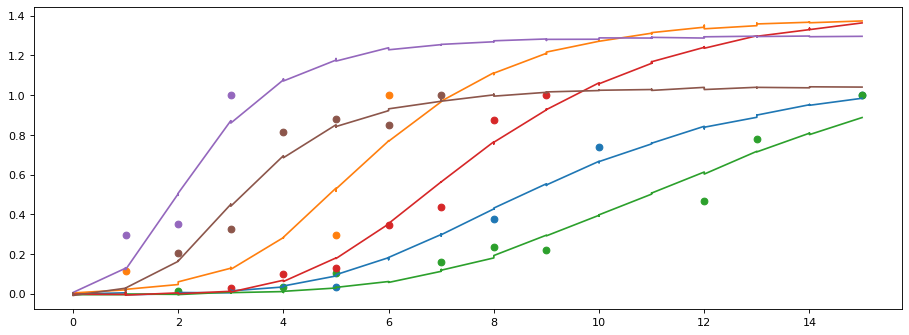

In [152]:
def plot_posterior(df, model, trace):
    plt.figure(figsize=(14,5), dpi=80)
    for sid, group in df.groupby("s_id"):
        plt.scatter(group.age, (group.mass_norm))

        ages = np.linspace(0, 15, 50).astype(int)
        posterior = utils.link(model, trace, age=ages, s_id=[sid]*len(ages))

        pred = posterior.posterior_predictive["mass"][0].mean(axis=0)
        plt.plot(ages, pred)

    # hdi = az.stats.hdi(posterior.posterior_predictive, hdi_prob=0.89)["mass"].values
    # plt.fill_between(ages, hdi[:, 0], hdi[:, 1], alpha=0.5)

plot_posterior(df, model5, samples5)
